# Social_Network_for_Code_Lyoko

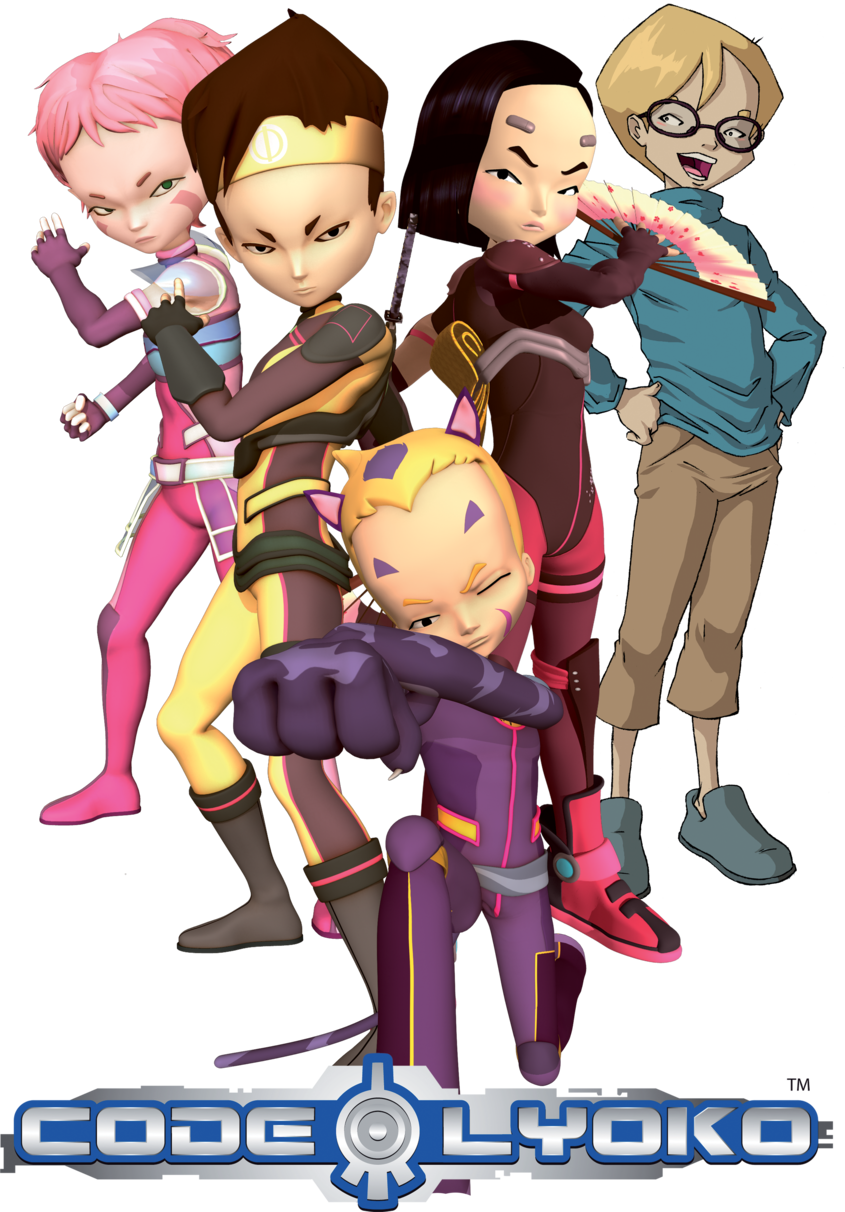

**Source**: *https://www.codelyoko.fr/*

## Problem Statement

El objetivo de este proyecto es la elaboración de un *Social Network Analysis (SNA)*, es decir, un proceso para analizar las relaciones que existen entre entidades sociales, en este caso los personajes del libro *Code Lyoko "The Underground Castle"*, en términos de teoría de redes y grafos. Dicho análisis implica el estudio empírico de cómo estos personajes interactúan entre sí dentro de la red.

## Import Packages

In [1]:
import re
import string
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import pandas as pd
import numpy as np
import networkx as nx
from pylab import rcParams
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Extract Text from a PDF Using PyMuPDF

In [2]:
# Import PyMuPDF
import fitz

# We need to set a variable to contain the path to our pdf file
my_path = 'Code_Lyoko_Chronicles-Book_1-The_Underground_Castle.pdf'

# Open with fitz
pdf = fitz.open(my_path)

# Load the required page (0-based index)
page = pdf[0]

# Extract all text
all_text = chr(12).join([page.get_text() for page in pdf])

# Save the text
text_file = open('Code_Lyoko_Chronicles-Book_1-The_Underground_Castle.txt', 'w')
text_file.write(all_text)
text_file.close()

## Data Reading

In [3]:
with open('Code_Lyoko_Chronicles-Book_1-The_Underground_Castle.txt') as f:
    text = f.read()
    
# Merge hyphenated words with newlines
text = re.sub(r'-\n(\w+ *)', r'\1\n', text)

## Clean Data

Antes de iniciar la identificación de los personajes se procederá con una limpieza del texto, que consistirá en la eliminación de signos de puntuación, la eliminación de *stopwords* y la conversión del texto a minúsculas. Se trata de una limpieza no muy exhaustiva que pretende mejorar el rendimiento de la extracción de los nombres de los personajes que figuran en el texto.

In [4]:
def remove_punctuations(txt):
    '''
    This function will remove punctuations from the input text
    '''
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\¿\\¡\\„\\“\\”\\ー\\©\\|\\«\\»\\€\\°\\¶\\¬\\‘\\’\\…]'
    txt = re.sub(regex , '', txt)
    return txt
  
def remove_stopwords(txt, sw = list(stopwords.words('english'))):
    '''
    This function will remove the stopwords from the input txt
    '''
    return ' '.join([w for w in txt.split() if w.lower() not in sw])

def clean_text(txt):
    '''
    This function will clean the text being passed by removing specific line feed characters
    like '\n', '\r', '\t', '\x0c', and '\'
    '''
    
    txt = txt.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').replace('\x0c', ' ').replace('\'', '')
    txt = remove_punctuations(txt)
    txt = remove_stopwords(txt)
    return txt.lower()
  
text = clean_text(text)

## Mining Character Names

Los nombres de los personajes y sus diferentes seudónimos son recopilados en un diccionario, con el objetivo de que estos sean encontrados en el texto.

In [5]:
known_names = {
    'jeremie' : ['jeremy', 'belpois'],
    'aelita' : ['maya', 'stones'],
    'philippe' : ['broulet'],
    'marie' : ['lemoine'],
    'roger crane' : ['roger', 'officer', 'policeman'],
    'rené crane' : ['rené'],
    'eva' : ['skinner'],
    'ulrich' : ['stern'],
    'odd' : ['della', 'robbia'],
    'yumi' : ['ishiyama'],
    'yukiko' : ['itou'],
    'franz hopper' : ['franz', 'hopper', 'waldo', 'schaeffer', 'daddy'],
    'bullenberg' : ['john'],
    'delmas' : ['principal'],
    'william' : ['dunbar'],
    'erik' : ['mckinsky'],
    'mark' : ['holeman'],
    'anthea' : ['mummy'],
    'erik’s mother' : ['mum'],
    'fernando' : ['mechanic'],
    'x.a.n.a.' : ['xana'],
    'robertson' : [],
    'tatillon' : [],
    'kiwi' : [],
    'rovvy' : [],
    'paul' : [],
    'françois' : [],
    'laurette' : [],
    'tom' : [],
    'matt' : [],
    'tonny' : [],
    'margie' : [],
    'jennifer' : [],
    'suzy' : [],
    'freno' : [],
    'gardenia' : [],
    'bumba' : [],
    'mistik' : [],
    'fumet' : [],
    'hertz' : []
}

def find_names(text, given_names):
    '''
    Given a body of text, this function will identify the names in that body of text
    by cross referencing list of names in the body of text
    
    params:
        text (String) : A body of text you want to parse through to identify names
        given_names (List / Dict) : The list / dictionary of known names in the body of 
                                    text, if the input is a dictionary, the keys are the
                                    main names and the values are a list of aliases
        
    returns:
        This function will return an updated given_names which holds the user input
    '''
    text = text.lower().split(' ')
    given_names_copy = given_names
    kn = []
    if type(given_names) == dict:
        for k,v in given_names_copy.items():
            if k not in v:
                given_names_copy[k].append(k)
        for k,v in given_names_copy.items():
            for name in v:
                kn.append(name)
    elif type(given_names) == list:
        for name in names:
            if name in text and name not in given_names:
                given_names.append(name)
    return given_names
    
found_names_dct = find_names(text, given_names = known_names)
print(f'El número total de personajes es de: {len(found_names_dct.keys())}.')

El número total de personajes es de: 40.


## Finding Character Interactions

Para detectar las interacciones entre personajes se empleará el enfoque basado en la coocurrencia, que consiste en descomponer la obra considerada en unidades narrativas más pequeñas, y en suponer que dos personajes interactúan cuando aparecen juntos dentro de la misma unidad. 

Se puede definir que dos personajes están interaccionando si sus nombres aparecen entre un periodo N de palabras, fijado en 15 en este caso.

In [6]:
N = 15
found_names = found_names_dct

def lower_known_names_dct(known_names):
    '''
    The purpose of this function is to add the key into the list of values
    as a lowered key
    '''
    if type(known_names) == list:
        known_names = {k:[k] for k in known_names}
        
    known_names_full = known_names.copy()
    for k,v in known_names_full.items():
        if k.lower not in v:
            v.append(k.lower())
    return known_names_full

found_names_full = lower_known_names_dct(known_names)

def generate_idx_dict(text, found_names_full):
    '''
    create an idx_dct where the keys are the idx of the names in
    the text and the values are the names
    '''
    res = dict()
    for i,word in enumerate(text.lower().split(' ')):
        for k,v in found_names_full.items():
            if word not in v:
                continue
            res[i] = k
    return res
idx_dct = generate_idx_dict(text, found_names_full)

def find_interactions(idx_dct, N):
    res = defaultdict(int)
    names = list(idx_dct.keys())
    
    for i,na in enumerate(names):
        # Given an index, get the sublist of all indicies greater than the current index
        if i < len(names) - 1:
            kl = names[i+1:]
        else:
            kl = []
        
        # For each idx greater than the current, check if its found in the range of N
        for k in kl:
            if k-na < N:
                # Get names found in current position (na) and index greater than current but in rnage N (k)
                n1 = idx_dct[na]
                n2 = idx_dct[k]
                
                key = tuple(sorted([n1,n2]))
                res[key]+=1
    return res

interactions_dct = find_interactions(idx_dct, N)
interactions_lst = list([(*k,v) for (k,v) in interactions_dct.items()])

## Creating Character Networks

Creación de un grafo ponderado, donde los nodos serán los propios personajes y las aristas se formarán a partir de las coocurrencias encontradas anteriormente. El peso de las aristas vendrá determinado por la frecuencia de las coocurrencias en el texto. Por ejemplo, si Jeremie y Aelita tienen 15 interacciones en el cuerpo del texto, el peso asociado a la arista que conecta a Jeremie con Aelita será 15.

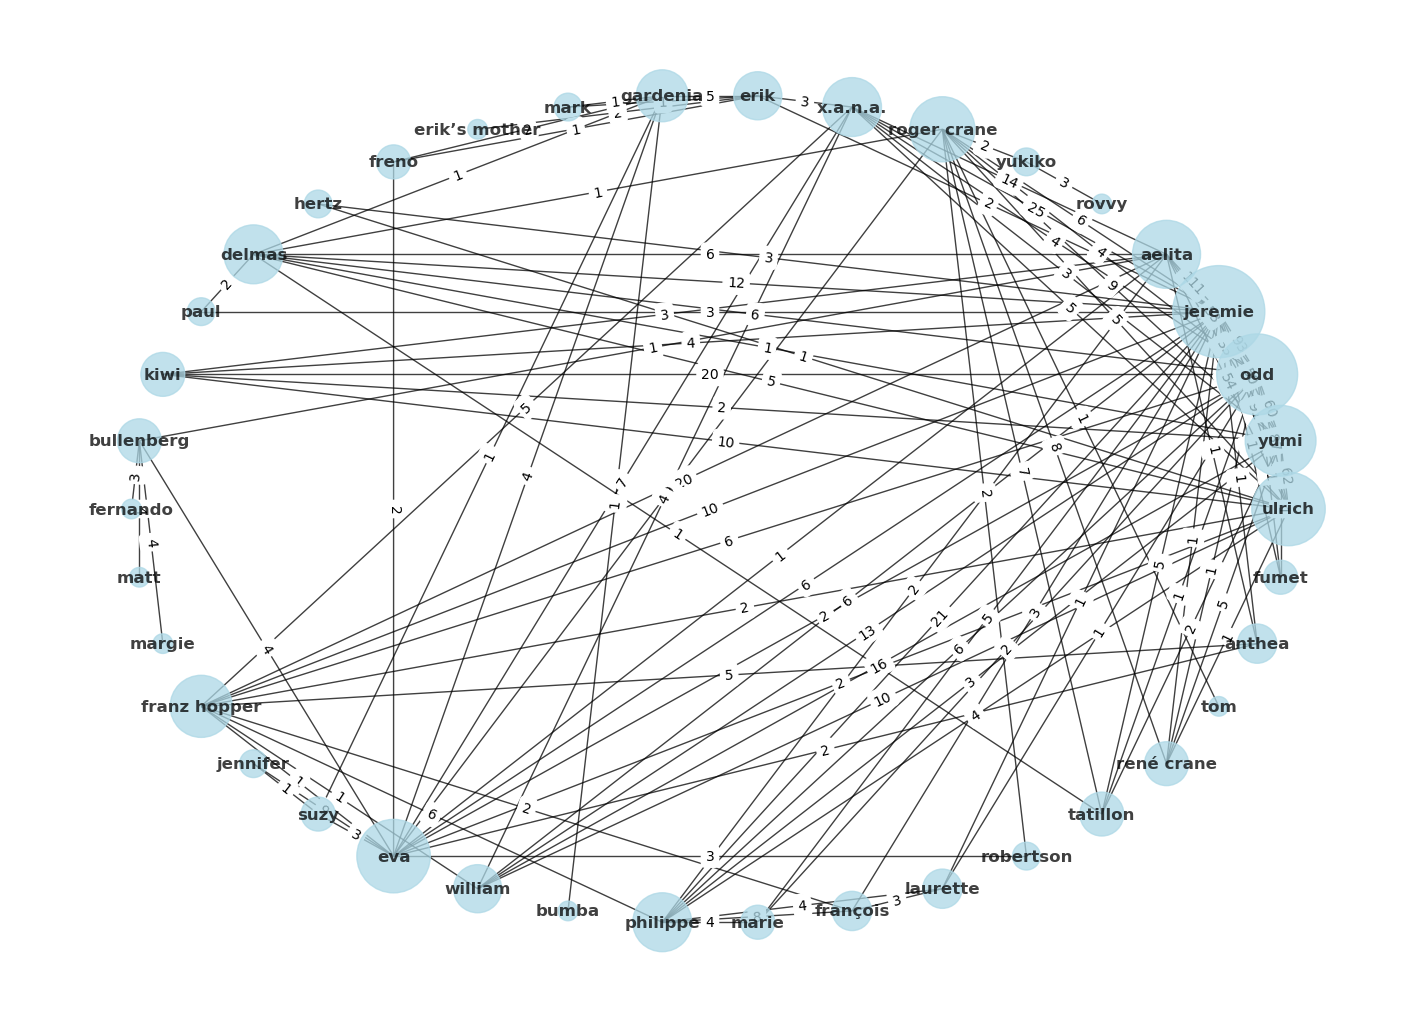

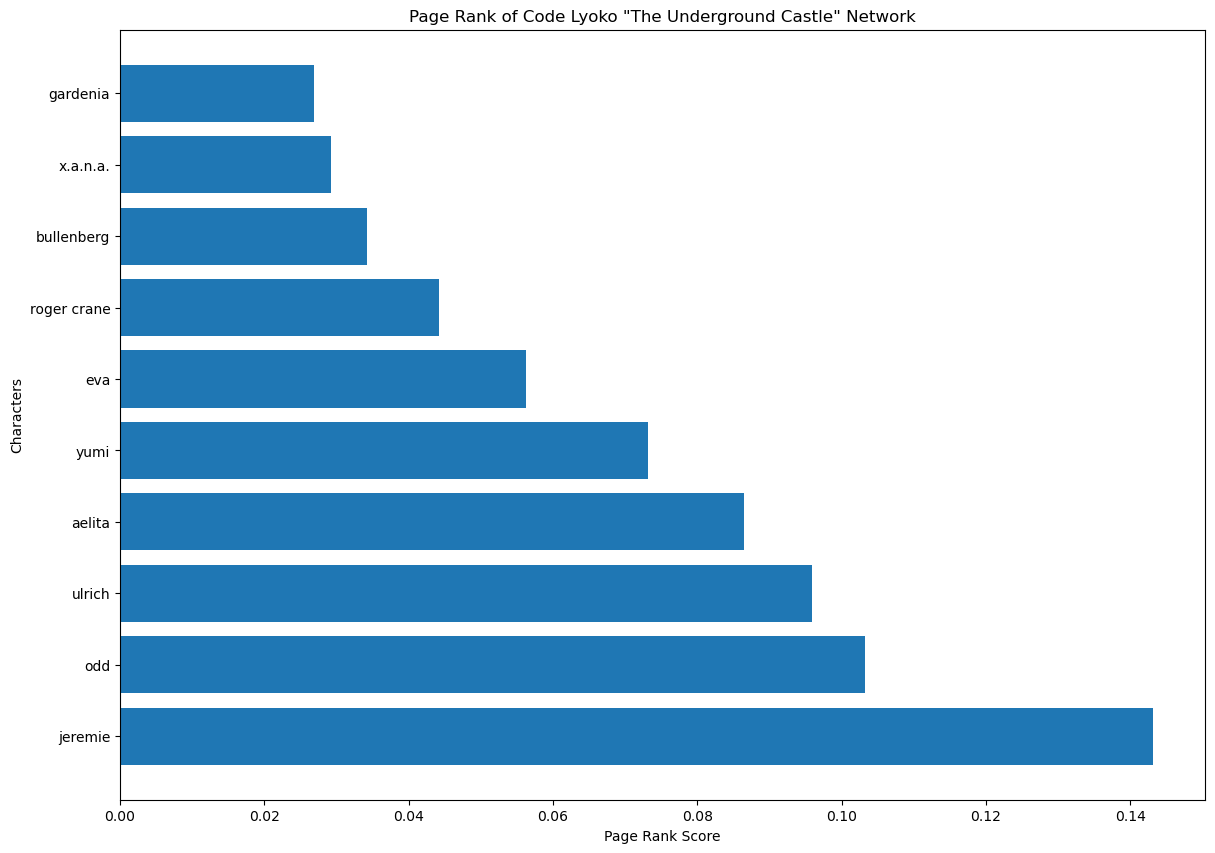

In [7]:
edges_df = pd.DataFrame(interactions_lst, columns = ['source', 'target', 'weight'])
# Delete own interactions
edges_df = edges_df.query('source != target').reset_index(drop=True)
G = nx.from_pandas_edgelist(edges_df, edge_attr = True)

# Visualize network
rcParams['figure.figsize'] = 14, 10
pos = nx.circular_layout(G, scale = 20)
labels = nx.get_edge_attributes(G, 'weight')
d = dict(G.degree)

nx.draw(
    G, 
    pos,
    node_color = 'lightblue', 
    alpha = 0.75,
    with_labels = True, 
    nodelist = d, 
    node_size=[d[k]*200 for k in d],
    font_weight = 'bold',
    font_size = 12,
    width = 1,
    edgelist = labels
)

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

pr = nx.pagerank(G)
pr = {k: v for k, v in sorted(pr.items(), reverse = True, key=lambda item: item[1])}
pr_df = pd.DataFrame([pr]).T.reset_index().rename(columns = {0 : 'pr', 'index' : 'name'})

# Visualize page rank to see character importance
plt.barh(y = pr_df['name'].head(10), width = pr_df['pr'].head(10))
plt.title('Page Rank of Code Lyoko "The Underground Castle" Network')
plt.ylabel('Characters')
plt.xlabel('Page Rank Score')
plt.show()

**Page Rank**: este algoritmo asigna un valor de importancia a cada nodo de la red basándose en el número de 
enlaces de entrada. El algoritmo da un mayor peso a aquellos enlaces recibidos de nodos más 
relevantes, por lo que el *PageRank* de un nodo está influenciado a su vez por el *PageRank* de 
otros nodos, ya que se calcula de forma recursiva. 

Este algoritmo cuenta la frecuencia de interacciones de calidad con un personaje para generar una estimación de la importancia del personaje. La expectativa es que los personajes con mayor importancia en la red reciban una mayor puntuación de *Page Rank*. En este caso, el personaje más relevante es Jeremie Belpois, seguido de sus compañeros Odd, Ulrich, Aelita y Yumi; tratándose de un resultado lógico, ya que son los protagonistas del libro.